Acceleromter Stuff
====
Initial investigation

In [3]:
from ema import read, parse, analysis

In [28]:
device_id = "6012582"
recording_id = "0000291121"
participant_id = "20029"

read.consented(participant_id)

12    1
Name: respondent_status, dtype: int64


c:\Users\mh19137\Documents\malaysia\ema\read.py:53: DtypeWarning: Columns (17,25,26,52,197,198,200,201,209,210,212,213,216,218,219,222,225,227,228,230,231,233,234,236,237,239,240,243,246,248,249,252,254,255,257,258,261,263,264,267,269,270,272,273,276,279,281,284,291,293,294,296,297,300,302,303,305,306,309,311,312,314,315,317,318,321,324,327,330,344,351,352,354,355,360,361,362,363,364,369,370,371,372,373,378,379,380,381,382,387,390,391,396,397,398,399,400,406,407,415,425,432,434,435,436,446,456,486,499,504,506,512,513,549) have mixed types. Specify dtype option on import or set low_memory=False.
  return pd.read_csv(path)


True

In [2]:
""" Find the accelerometer file """
import pathlib

device_id = "6012582"
recording_id = "0000291121"
participant_id = "20029"

# Check IDs are the right length
assert len(str(device_id)) == 7
assert len(str(recording_id)) == 10

# TODO Check that the participant agreed to take part in the study
# Do this by opening "Z:\SEACO data\SEACO-CH20 qnaire data\SEACO_CH20_17082022_de_id.csv"
# as a dataframe, finding the row with participant_id = df["residents_id"] and checking
# that the value of "respondent_status" here == 1
# I've checked the one above by hand and it's fine
...

filename = f"{device_id}_{recording_id}-{participant_id}.cwa"
filepath = pathlib.Path(rf"data/{filename}")

# TODO add some code to look for the right file in all the "Week X" folders

assert filepath.exists()

In [3]:
""" Find the smartwatch data from the combined smartwatch file """
meal_df = read.meal_info(participant_id)
allowed_meal_types = {"Snack", "Drink", "Meal", "No food/drink"}
meal_df = parse.extract_meals(meal_df, allowed_meal_types, verbose=True)

Discarding: {'Catch-up end': 1, 'Catch-up start': 1, 'No catch-up': 2, 'No response': 72}
Kept: {'Drink': 35, 'Meal': 37, 'No food/drink': 4, 'Snack': 2}


In [4]:
""" Read the accelerometry file """
samples = read.accel_info(str(filepath))

0          2021-11-30 01:00:07.060058624
1          2021-11-30 01:00:07.070008064
2          2021-11-30 01:00:07.079957504
3          2021-11-30 01:00:07.089907200
4          2021-11-30 01:00:07.099856640
                        ...             
60786435   2021-12-07 01:00:01.038818304
60786436   2021-12-07 01:00:01.048766976
60786437   2021-12-07 01:00:01.058715904
60786438   2021-12-07 01:00:01.068664576
60786439   2021-12-07 01:00:01.078613248
Name: time, Length: 60786440, dtype: datetime64[ns]


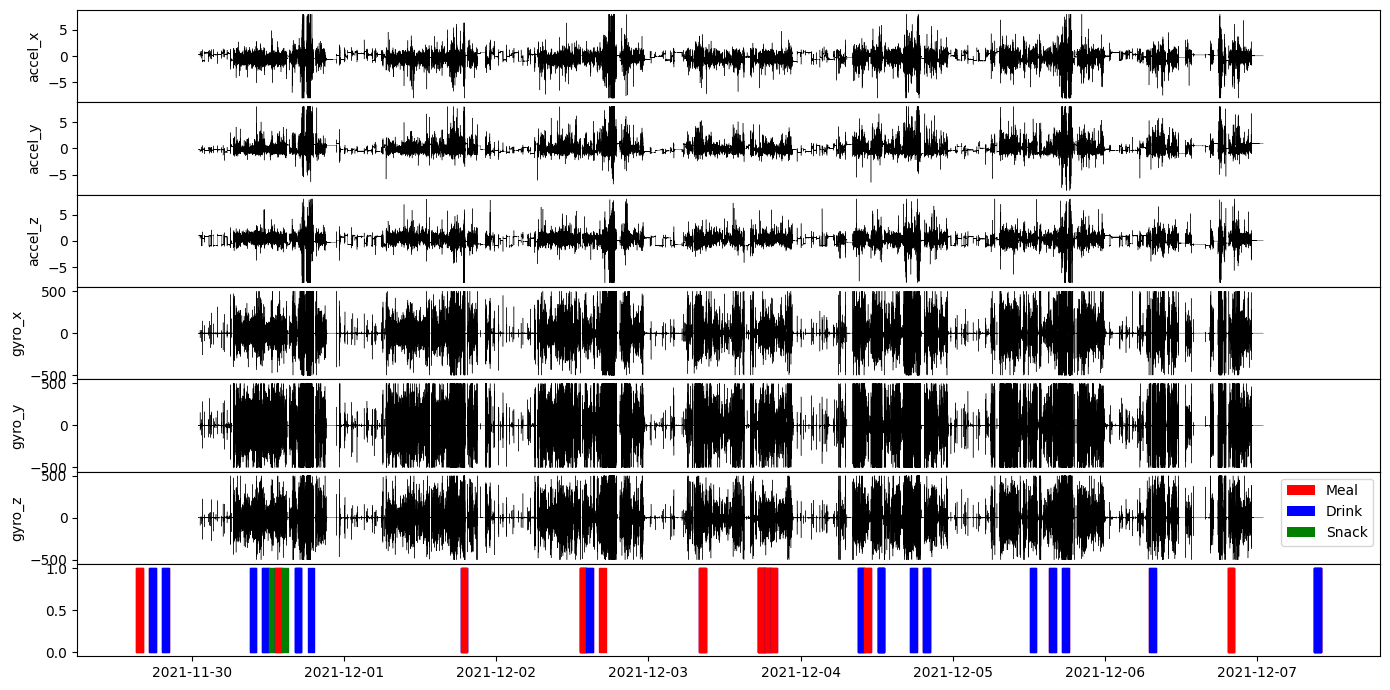

In [5]:
""" Plot each component of acceleration and the meal times """
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.patches import Patch

times = samples["time"]

fig, axes = plt.subplots(
    7,
    1,
    figsize=(14, 7),
    sharex=True,
)
fig.subplots_adjust(hspace=0.0)

# TODO add rotation column titles
column_titles = [f"accel_{p}" for p in ("x", "y", "z")] + [
    f"gyro_{p}" for p in ("x", "y", "z")
]

for col, axis in zip(column_titles, axes):
    axis.plot(times[::20], samples[col][::20], linewidth=0.3, color="k")
    axis.set_ylabel(col)

# Plot also the meal times on the bottom axis
print(times)
meal_times = meal_df["date"].map(str) + meal_df["timestamp"]

ends = pd.to_datetime(meal_times, format=r"%d%b%Y%H:%M:%S")
starts = ends - pd.Timedelta(1, "hour")

colours = {"Meal": "r", "Drink": "b", "Snack": "g"}
for start, end, meal_type in zip(starts, ends, meal_df["meal_type"]):
    if meal_type in colours:
        axes[6].fill_between(
            [start, end], [0.0, 0.0], [1.0, 1.0], color=colours[meal_type]
        )

axes[-2].legend(handles=[Patch(facecolor=v, label=k) for k, v in colours.items()])

fig.tight_layout()
fig.subplots_adjust(hspace=0.0)

In [6]:
import pyscamp
pyscamp.gpu_supported()


True

In [7]:
""" Find the matrix profile for one of our variables """
arr = samples["accel_x"][::50].to_numpy()
times = times[::50]
profile, indices = pyscamp.selfjoin(arr, 5000)

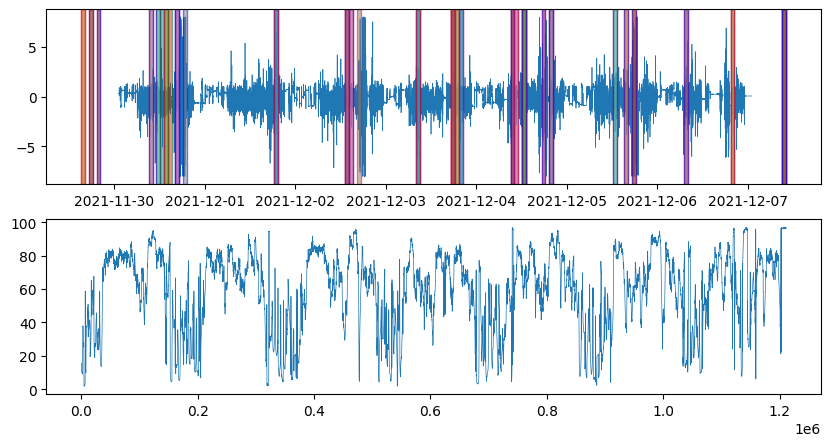

In [24]:
import numpy as np

fig, ax = plt.subplots(2, 1, figsize=(10, 5))
ax[0].plot(times, arr, linewidth=0.5, zorder=1)
ax[1].plot(np.arange(len(profile)), profile, linewidth=0.5)

for start, end, meal_type in zip(starts, ends, meal_df["meal_type"]):
    if meal_type in colours:
        ylim = ax[0].get_ylim()
        ax[0].fill_between(
            [start, end],
            [ylim[0]] * 2,
            [ylim[1]] * 2,
            # facecolor=colours[meal_type],
            edgecolor=colours[meal_type],
            zorder=2,
            alpha=0.5
        )
        ax[0].set_ylim(ylim)